# Lab 2 - Singal Generation and Capture

## Task 1 - Simple sinewave generator

### Step 1 - Specifying a 256 X 8 bit ROM
> Create the component `rom.sv` according to Lecture 4 

`rom.sv`
```verilog
module rom  #(
    parameter   ADDRESS_WIDTH = 8, 
                DATA_WIDTH = 8    
) (
    input logic                     clk, 
    input logic [ADDRESS_WIDTH-1:0] addr,
    output logic [DATA_WIDTH-1:0]   dout 
); 

logic [DATA_WIDTH-1:0]  rom_array [2**ADDRESS_WIDTH-1:0];

initial begin
    $display("Loading rom.");
    $readmemh("sinerom.mem", rom_array);
end

always_ff @(posedge clk) 
    // output is synchronous
    dout <= rom_array[addr];

endmodule

```

`counter.sv`
```verilog
module counter #(
    parameter WIDTH = 8
)(
    // interface signals
    input logic                 clk,        // clock
    input logic                 rst,        // reset
    input logic                 en,         // counter enable
    input logic [WIDTH-1:0]     incr,       
    output logic [WIDTH-1:0]    count
);

always_ff @ (posedge clk)
    if (rst) count <= {WIDTH{1'b0}};
    //add incr, and the increment of incr each time
    else     count <= count + incr + {{WIDTH-1{1'b0}}, en}; 
    
endmodule
```

### Step 2 - Create the sinegen module
> Create a top-level module `sinegen.sv`, which includes two components: `counter.sv` and `rom.sv`, as shown in the diagram. 

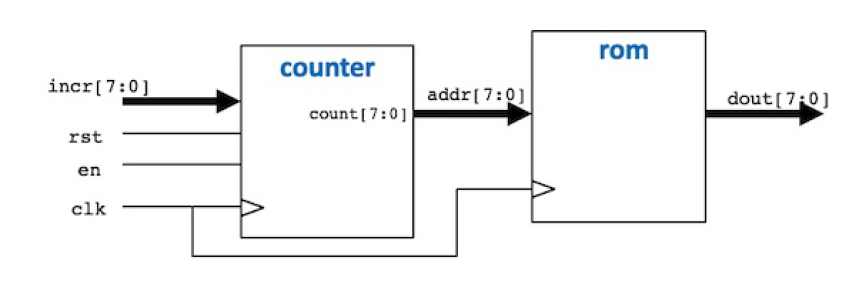

`sinegen.sv`
```systemverilog
module sinegen #(
    parameter   A_WIDTH = 8, 
                D_WIDTH = 8  
    ) (
        // interface signals
        input logic                     clk, 
        input logic                     rst, 
        input logic                     en, 
        input logic     [D_WIDTH-1:0]   incr, 
        output logic    [D_WIDTH-1:0]   dout
    );

        logic [A_WIDTH-1:0]             address;

    counter addrCounter (
        .clk(clk), 
        .rst(rst), 
        .en(en), 
        .incr(incr),                    
        // count is internal name, address is external name
        .count(address)                 
    );

    rom sinerom (
        .clk(clk), 
        .addr(address), 
        .dout(dout)
    );

endmodule

```

### Step 3 - Create the testbench for sinegen
> Try to write the testbench `sinegen_tb.cpp` on your own.<br>
> Simulation cycle should be increased to a large value <br>
> `incr[7:0]` should be set to 1<br>
> `vbdPlot()` function is used to plot data <br>
> Use the `vbdGetkey()` funtion (check if a key has been pressed) to implement termination
>```c++
>// either simulation finished, or 'q' is pressed
>if ((Verilated::gotFinish()) || (vbdGetkey()=='q')) 
>    exit(0);                // ... exit if finish OR 'q' pressed
>```

```c++
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "Vsinegen.h"

#include "vbuddy.cpp"     // include vbuddy code
#define MAX_SIM_CYC 1000000
#define ADDRESS_WIDTH 8
#define ROM_SZ 256

int main(int argc, char **argv, char **env) {
  int simcyc;     // simulation clock count
  int tick;       // each clk cycle has two ticks for two edges

  Verilated::commandArgs(argc, argv);
  // init top verilog instance
  Vsinegen* top = new Vsinegen;
  // init trace dump
  Verilated::traceEverOn(true);
  VerilatedVcdC* tfp = new VerilatedVcdC;
  top->trace (tfp, 99);
  tfp->open ("sinegen.vcd");
 
  // init Vbuddy
  if (vbdOpen()!=1) return(-1);
  vbdHeader("L2T1: SigGen");
  //vbdSetMode(1);        // Flag mode set to one-shot

  // initialize simulation inputs
  top->clk = 1;
  top->rst = 0;
  top->en = 1;
  top->incr = 1;

  // run simulation for MAX_SIM_CYC clock cycles
  for (simcyc=0; simcyc<MAX_SIM_CYC; simcyc++) {
    // dump variables into VCD file and toggle clock
    for (tick=0; tick<2; tick++) {
      tfp->dump (2*simcyc+tick);
      top->clk = !top->clk;
      top->eval ();
    }

    // plot ROM output and print cycle count
    vbdPlot(int (top->dout), 0, 255);
    vbdCycle(simcyc);

    // either simulation finished, or 'q' is pressed
    if ((Verilated::gotFinish()) || (vbdGetkey()=='q')) 
      exit(0);                // ... exit if finish OR 'q' pressed
  }

  vbdClose();     // ++++
  tfp->close(); 
  exit(0);
}
```

### Step 4 - Modify the shell script `doit.sh` 

```
#!/bin/sh

# cleanup
rm -rf obj_dir
rm -f sinegen.vcd

#run Verilator to translate Verilog to C++, including C++ testbench
verilator -Wall --cc --trace sinegen.sv --exe sinegen_tb.cpp

#build C++ project via make automatically generated by Verilator
make -j -C obj_dir/ -f Vsinegen.mk Vsinegen

#run executable simulation file
obj_dir/Vsinegen
```

### Step 5 - Challenge

> Modify the design so that you use the `vbdValue()` function to change the frequency of the sinewave generated. 

Make change on the test bench, to adjust the "step" of the change of `count`, so as to modify the frequency
```c++
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "Vsinegen.h"

#include "vbuddy.cpp"     // include vbuddy code
#define MAX_SIM_CYC 1000000
#define ADDRESS_WIDTH 8
#define ROM_SZ 256

int main(int argc, char **argv, char **env) {
  int simcyc;     // simulation clock count
  int tick;       // each clk cycle has two ticks for two edges

  Verilated::commandArgs(argc, argv);
  // init top verilog instance
  Vsinegen* top = new Vsinegen;
  // init trace dump
  Verilated::traceEverOn(true);
  VerilatedVcdC* tfp = new VerilatedVcdC;
  top->trace (tfp, 99);
  tfp->open ("sinegen.vcd");
 
  // init Vbuddy
  if (vbdOpen()!=1) return(-1);
  vbdHeader("L2T1: SigGen");
  //vbdSetMode(1);        // Flag mode set to one-shot

  // initialize simulation inputs
  top->clk = 1;
  top->rst = 0;
  top->en = 1;
  top->incr = 1;

  // run simulation for MAX_SIM_CYC clock cycles
  for (simcyc=0; simcyc<MAX_SIM_CYC; simcyc++) {
    // dump variables into VCD file and toggle clock
    for (tick=0; tick<2; tick++) {
      tfp->dump (2*simcyc+tick);
      top->clk = !top->clk;
      top->eval ();
    }
    
    // modify the step
    top->incr = vbdValue();
    // plot ROM output and print cycle count
    vbdPlot(int (top->dout), 0, 255);
    vbdCycle(simcyc);

    // either simulation finished, or 'q' is pressed
    if ((Verilated::gotFinish()) || (vbdGetkey()=='q')) 
      exit(0);                // ... exit if finish OR 'q' pressed
  }

  vbdClose();     // ++++
  tfp->close(); 
  exit(0);
}
```

## Task 2 - Sine and Cosine Dual wave generation

> Modify the design in Task 1 to generate two simultaenous sinusoid signals which have different phases<br>

- A dual port ROM is used. The first port's address `addr1[7:0]` is from the counter, the second port's address `addr[7:0]` is offset from the first address. 
- The offset is read from Vbuddy with the `vbdValue()` function. 
- `vbdPlot()` function is called twice to display two waveforms on Vbuddy. 

`counter_with_load.sv`
```verilog
module counter_with_load #(
    parameter WIDTH = 8
)(
    // interface signals
    input logic                 clk,        // clock
    input logic                 rst,        // reset
    input logic                 en,         // counter enable
    input logic [WIDTH-1:0]     incr,
    output logic [WIDTH-1:0]    count, 
    output logic [WIDTH-1:0]    count_with_load
);

always_ff @ (posedge clk)   begin   
    if (rst) count <= {WIDTH{1'b0}};
    else     count <= count + {{WIDTH-1{1'b0}}, en};
    count_with_load <= count + incr + {{WIDTH-1{1'b0}}, en};
    end
endmodule

```

`rom2ports.sv`
```verilog
module rom2ports  #(
    parameter   ADDRESS_WIDTH = 8, 
                DATA_WIDTH = 8    
) (
    input logic                     clk, 
    input logic [ADDRESS_WIDTH-1:0] addr1,
    input logic [ADDRESS_WIDTH-1:0] addr2,
    output logic [DATA_WIDTH-1:0]   dout1, 
    output logic [DATA_WIDTH-1:0]   dout2 
); 

logic [DATA_WIDTH-1:0]  rom_array [2**ADDRESS_WIDTH-1:0];

initial begin
    $display("Loading rom.");
    $readmemh("sinerom.mem", rom_array);
end

always_ff @(posedge clk)    begin 
    // output is synchronous
    dout1 <= rom_array [addr1];
    dout2 <= rom_array [addr2];
    end

endmodule

```

`sinegen.sv`
```verilog
module sinegen #(
    parameter   A_WIDTH = 8, 
                D_WIDTH = 8  
    ) (
        // interface signals
        input logic                     clk, 
        input logic                     rst, 
        input logic                     en, 
        input logic     [A_WIDTH-1:0]   incr, 
        output logic    [D_WIDTH-1:0]   dout1, 
        output logic    [D_WIDTH-1:0]   dout2
    );

        logic [A_WIDTH-1:0]             address1;
        logic [A_WIDTH-1:0]             address2;

    counter_with_load addrCounter (
        .clk(clk), 
        .rst(rst), 
        .en(en), 
        .incr(incr),  
        .count(address1), 
        .count_with_load(address2)
    );

    rom2ports sinerom (
        .clk(clk), 
        .addr1(address1),
        .addr2(address2), 
        .dout1(dout1), 
        .dout2(dout2)
    );

endmodule

```

`testbench`
```c++
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "Vsinegen.h"

#include "vbuddy.cpp"     // include vbuddy code
#define MAX_SIM_CYC 1000000
#define ADDRESS_WIDTH 8
#define ROM_SZ 256

int main(int argc, char **argv, char **env) {
  int simcyc;     // simulation clock count
  int tick;       // each clk cycle has two ticks for two edges

  Verilated::commandArgs(argc, argv);
  // init top verilog instance
  Vsinegen* top = new Vsinegen;
  // init trace dump
  Verilated::traceEverOn(true);
  VerilatedVcdC* tfp = new VerilatedVcdC;
  top->trace (tfp, 99);
  tfp->open ("sinegen.vcd");
 
  // init Vbuddy
  if (vbdOpen()!=1) return(-1);
  vbdHeader("L2T1: SigGen");
  //vbdSetMode(1);        // Flag mode set to one-shot

  // initialize simulation inputs
  top->clk = 1;
  top->rst = 0;
  top->en = 1;
  top->incr = 1;


  // run simulation for MAX_SIM_CYC clock cycles
  for (simcyc=0; simcyc<MAX_SIM_CYC; simcyc++) {
    // dump variables into VCD file and toggle clock
    for (tick=0; tick<2; tick++) {
      tfp->dump (2*simcyc+tick);
      top->clk = !top->clk;
      top->eval ();
    }
    
    top->incr = vbdValue();
    // plot ROM output and print cycle count
    vbdPlot(int (top->dout1), 0, 255);
    vbdPlot(int (top->dout2), 0, 255);
    vbdCycle(simcyc);

    // either simulation finished, or 'q' is pressed
    if ((Verilated::gotFinish()) || (vbdGetkey()=='q')) 
      exit(0);                // ... exit if finish OR 'q' pressed
  }

  vbdClose();     // ++++
  tfp->close(); 
  exit(0);
}
```

## Task 3 - Capture and display audio signal in RAM

> The goal is to capture real audio signal using the microphone/amplifier module on Vbuddy. These samples are written to a dual-port RAM stored in successive locations. At the same time, read from RAM at a adress with an offset. <br><br> In this way, the retrieved signal is a delayed version of the original signal. 

- Capture audio signal from Vbuddy<br>
$\textcircled{1}$ Use the `vbdInitMicIn()` function to inform Vbuddy the size of audio signal buffer to reserve for storing the captured sample. <br>
$\textcircled{2}$ Use the `vbdMicValue()` function to return the next sample in the aduio buffer. When all the samples are exhausted, Vbuddy will automatically capture another block of audio samples and store them in the audio buffer. 


> To perform this task a 512 x 8 bit dual-port RAM is needed. Combine the dual-port RAM with the counter to form a top-level module. 

`counter_with_load.sv`

```verilog
module counter_with_load #(
    parameter WIDTH = 9
)(
    // interface signals
    input logic                 clk,        // clock
    input logic                 rst,        // reset
    input logic                 en,         // counter enable
    input logic [WIDTH-1:0]     incr,
    output logic [WIDTH-1:0]    count, 
    output logic [WIDTH-1:0]    count_with_load
);

always_ff @ (posedge clk)   begin   
    if (rst)    count <= {WIDTH{1'b0}};
    else        count <= count + {{WIDTH-1{1'b0}}, en};                     //read_address, delayed 
                count_with_load <= count + incr + {{WIDTH-1{1'b0}}, en} ;   //write_address, lead
    end
endmodule

```

`ram2ports.sv`
```verilog
module ram2ports  #(
    parameter   DATA_WIDTH = 9, 
                ADDR_WIDTH = 8
 ) (
    input logic                     clk, 
    input logic                     wr_en, 
    input logic                     rd_en, 
    input logic [ADDR_WIDTH-1:0]    wr_addr, 
    input logic [ADDR_WIDTH-1:0]    rd_addr, 
    input logic [DATA_WIDTH-1:0]    din, 
    output logic [DATA_WIDTH-1:0]   dout
);

logic [DATA_WIDTH-1:0] ram_array [2**ADDR_WIDTH-1:0];

always_ff @(posedge clk) begin
    if (wr_en == 1'b1)
        ram_array[wr_addr] <= din;
    if (rd_en == 1'b1)
        dout <= ram_array[rd_addr];
end
endmodule

```

`sigdelay.sv`
```systemverilog
module sigdelay #(
    parameter   A_WIDTH = 9, 
                D_WIDTH = 8
   )   (
    input logic                 clk, 
    input logic                 rst,
    input logic                 en,
    input logic                 wr,
    input logic                 rd,
    input logic [A_WIDTH-1:0]   incr,
    input logic [A_WIDTH-1:0]   offset,
    input logic [D_WIDTH-1:0]   mic_signal,
    output logic [D_WIDTH-1:0]  delayed_signal
);

    logic [A_WIDTH-1:0]         write_address;
    logic [A_WIDTH-1:0]         read_address;

counter_with_load delaycounter    (
    .clk(clk),
    .rst(rst),
    .en(en),
    .incr(incr),
    .count(read_address), 
    .count_with_load(write_address)
);

ram2ports delayram (
    .clk(clk),
    .wr_en(wr),
    .rd_en(rd),
    .wr_addr(write_address),
    .rd_addr(read_address),
    .din(mic_signal),
    .dout(delayed_signal)
);

endmodule 

```

`testbench`
```c++
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "Vsigdelay.h"

#include "vbuddy.cpp"     // include vbuddy code
#define MAX_SIM_CYC 1000000
#define ADDRESS_WIDTH 9
#define RAM_SZ pow(2,ADDRESS_WIDTH)

int main(int argc, char **argv, char **env) {
  int simcyc;     // simulation clock count
  int tick;       // each clk cycle has two ticks for two edges

  Verilated::commandArgs(argc, argv);
  // init top verilog instance
  Vsigdelay* top = new Vsigdelay;
  // init trace dump
  Verilated::traceEverOn(true);
  VerilatedVcdC* tfp = new VerilatedVcdC;
  top->trace (tfp, 99);
  tfp->open ("sigdelay.vcd");
 
  // init Vbuddy
  if (vbdOpen()!=1) return(-1);
  vbdHeader("L2T3:Delay");
  //vbdSetMode(1);        // Flag mode set to one-shot

  // initialize simulation input 
  top->clk = 1;
  top->rst = 0;
  top->en = 1;            // An additional initialisation of en added to the testbench 
  top->wr = 1;
  top->rd = 1;
  top->offset = 64;
  
  // intialize variables for analogue output
  vbdInitMicIn(RAM_SZ);

  // run simulation for MAX_SIM_CYC clock cycles
  for (simcyc=0; simcyc<MAX_SIM_CYC; simcyc++) {
    // dump variables into VCD file and toggle clock
    for (tick=0; tick<2; tick++) {
      tfp->dump (2*simcyc+tick);
      top->clk = !top->clk;
      top->eval ();
    }
    top->mic_signal = vbdMicValue();
    top->incr = abs(vbdValue());     // adjust delay by changing incr

    // plot RAM input/output, send sample to DAC buffer, and print cycle count
    vbdPlot(int (top->mic_signal), 0, 255);
    vbdPlot(int (top->delayed_signal), 0, 255);
    vbdCycle(simcyc);

    // either simulation finished, or 'q' is pressed
    if ((Verilated::gotFinish()) || (vbdGetkey()=='q')) 
      exit(0);
  }

  vbdClose();     // ++++
  tfp->close(); 
  printf("Exiting\n");
  exit(0);
}

```